In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Input Data and EAD

In [2]:
titanic_data = pd.read_csv("data/train.csv")
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_test = pd.read_csv("data/test.csv")
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,Survived,PassengerId
0,0,549
1,1,342


<AxesSubplot:xlabel='Survived', ylabel='PassengerId'>

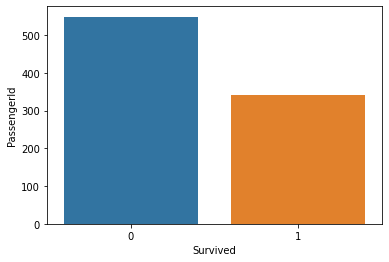

In [5]:
survival = titanic_data.groupby(["Survived"])['PassengerId'].count().reset_index()
display(survival)
sns.barplot(survival["Survived"],survival["PassengerId"])

<Figure size 2160x360 with 0 Axes>

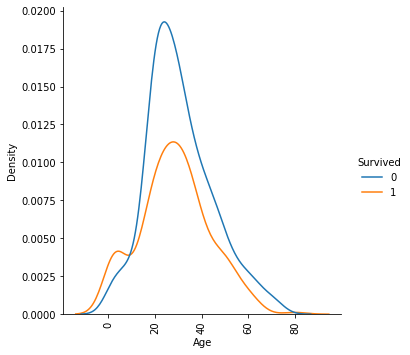

In [6]:
plt.figure(figsize=(30,5))
sns.displot(x='Age', hue='Survived', data=titanic_data, kind='kde');
plt.xticks(rotation=90)
plt.show()

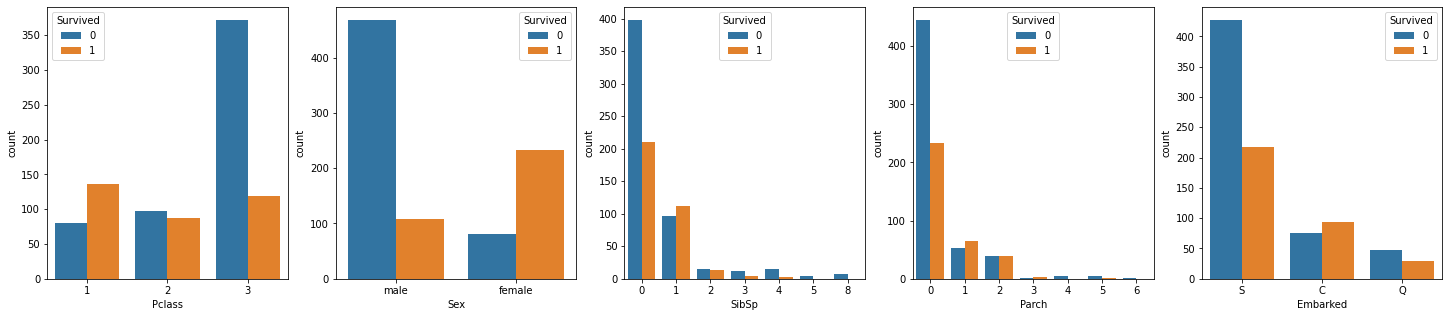

In [7]:
x_label = ["Pclass","Sex","SibSp","Parch","Embarked"]
y_label = ['Survived']
fig, ax = plt.subplots(len(y_label),len(x_label), figsize=(5*len(x_label),5))

for y in y_label:
    for x_index in range(len(x_label)):
        sns.countplot(titanic_data[x_label[x_index]], hue = titanic_data[y],ax = ax[x_index])

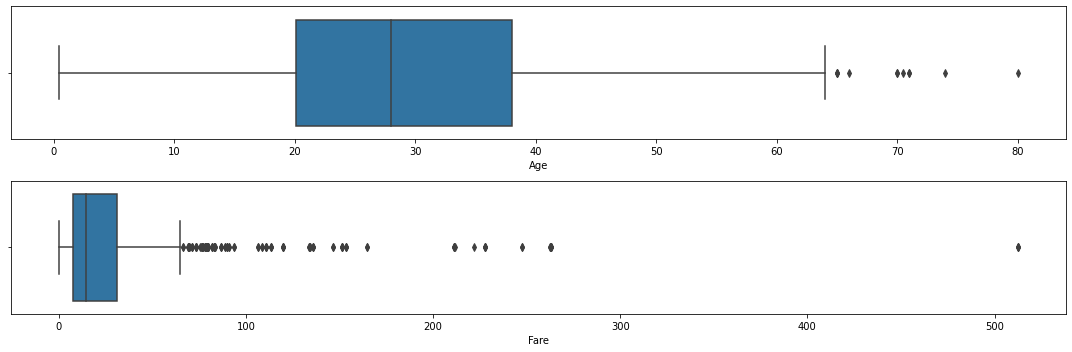

In [8]:
list2 = ['Age','Fare']
fig, axes = plt.subplots(2,1, figsize=(15,5))
for i in range(0, len(list2)):
    sns.boxplot(titanic_data[list2[i]], orient='h',ax = axes[i])
    plt.tight_layout()
plt.show()

In [9]:
# fig, axes = plt.subplots(1,1, figsize=(20,5))
# plt.tight_layout()
uniqueValues = titanic_data['Embarked'].unique()
print(uniqueValues)

['S' 'C' 'Q' nan]


# Proprocessing the Data

Embarked<br>
S:1, C:2, Q:3, nan:0<br>
Sex<br>
Female:1, Male:2

In [10]:
import copy

In [11]:
def process_data(data):
    titanic_temp = copy.deepcopy(data)
    key_removed = ["Ticket","PassengerId","Cabin","Name"]
    for key in key_removed:
        titanic_temp.pop(key)


    to_repalce = {
        'Sex': {'female':1, 'male':2},
        'Embarked': {'S':1, 'C':2, 'Q':3}
    }

    titanic_temp = titanic_temp.replace(to_replace = to_repalce)
    titanic_temp = titanic_temp.fillna(0)
    return titanic_temp

# Logistic Regression

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data_utils

In [13]:
class logisticRegression(nn.Module):
    
    def __init__(self):
        super(logisticRegression, self).__init__()
        self.fc1 = nn.Linear(7, 1)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x


In [14]:
titanic_temp =  process_data(titanic_data)
train_target = torch.tensor(titanic_temp['Survived'].values.astype(np.float64))
train = torch.tensor(titanic_temp.drop('Survived', axis = 1).values.astype(np.float64)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 50, shuffle = True)

In [15]:
def train(titanic_LR_model, train_loader,epoches):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(titanic_LR_model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(epoches):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            labels = labels.unsqueeze(1)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = titanic_LR_model(inputs.float())
            labels = labels.float()

            loss = criterion(outputs.float(), labels)
            loss.backward()
            optimizer.step()
            
            # print statistics
            running_loss += loss.item()
            print(loss.item())
        print("round " + str(epoch))
    print('Finished Training')


In [16]:
titanic_LR_model = logisticRegression().float()
train(titanic_LR_model,train_loader, epoches = 100)

0.41977256536483765
0.35698845982551575
0.3445596694946289
0.2900468409061432
0.3228481709957123
0.3712899088859558
0.33614394068717957
0.32385051250457764
0.3655535876750946
0.33010414242744446
0.3535862863063812
0.3363446295261383
0.29422950744628906
0.39093121886253357
0.3554520308971405
0.44333359599113464
0.34230148792266846
0.3866126537322998
round 0
0.2697470486164093
0.4741384983062744
0.3818741738796234
0.30227500200271606
0.30197227001190186
0.34725528955459595
0.2755226194858551
0.32655200362205505
0.3067067861557007
0.26146191358566284
0.29870355129241943
0.31664595007896423
0.36591434478759766
0.3566775619983673
0.3327183127403259
0.2770073413848877
0.27186426520347595
0.30115649104118347
round 1
0.3406522870063782
0.2810770273208618
0.25408706068992615
0.2778860926628113
0.21215416491031647
0.23924310505390167
0.21065758168697357
0.23851150274276733
0.20428617298603058
0.31974345445632935
0.43798789381980896
0.34332576394081116
0.20209568738937378
0.34315502643585205
0.19

0.20154987275600433
0.22069557011127472
0.17684811353683472
0.21254947781562805
0.20975618064403534
0.1641651690006256
0.19877544045448303
0.19138064980506897
0.14268486201763153
0.1868320256471634
round 27
0.17858843505382538
0.2454884946346283
0.22506862878799438
0.28855830430984497
0.2935919165611267
0.19895313680171967
0.22620971500873566
0.2037511020898819
0.2280573695898056
0.19845370948314667
0.23406308889389038
0.25010621547698975
0.2588869333267212
0.2364264726638794
0.17627237737178802
0.1336735039949417
0.24834637343883514
0.2768128216266632
round 28
0.19547735154628754
0.24412496387958527
0.2264384627342224
0.22834210097789764
0.10549020767211914
0.22669176757335663
0.19588293135166168
0.1566953808069229
0.2019999921321869
0.21864666044712067
0.22120948135852814
0.15528544783592224
0.13380764424800873
0.20656485855579376
0.25541648268699646
0.19741006195545197
0.1998271942138672
0.19935740530490875
round 29
0.14747072756290436
0.173823744058609
0.21992763876914978
0.2040525

0.21240825951099396
0.17798320949077606
0.17163380980491638
0.21151715517044067
0.14040778577327728
0.19508492946624756
0.18356314301490784
0.16991516947746277
round 55
0.15691643953323364
0.15630610287189484
0.1207902804017067
0.14086487889289856
0.2237425297498703
0.09623158723115921
0.23669013381004333
0.15410561859607697
0.2183629870414734
0.16620157659053802
0.232998788356781
0.12868595123291016
0.19037185609340668
0.13579526543617249
0.16262611746788025
0.20265211164951324
0.21765632927417755
0.17389652132987976
round 56
0.1924818754196167
0.12404703348875046
0.1903463900089264
0.2309342920780182
0.2388482540845871
0.1456795185804367
0.198122039437294
0.13102836906909943
0.2629675567150116
0.1932421326637268
0.22895318269729614
0.28464969992637634
0.16947104036808014
0.1416339874267578
0.14925843477249146
0.17413511872291565
0.15664343535900116
0.15843212604522705
round 57
0.22891530394554138
0.2514384984970093
0.14585371315479279
0.20538698136806488
0.19708490371704102
0.0909566

0.16958652436733246
0.15370379388332367
0.20865140855312347
0.13732321560382843
0.17553596198558807
0.21496856212615967
0.18121059238910675
0.17170752584934235
round 83
0.1444631963968277
0.21059207618236542
0.22396785020828247
0.23194743692874908
0.15642255544662476
0.2490607500076294
0.19402314722537994
0.15919247269630432
0.1109352707862854
0.21972551941871643
0.15923026204109192
0.1501748412847519
0.20283013582229614
0.1596999317407608
0.23299850523471832
0.14405398070812225
0.14127179980278015
0.15781742334365845
round 84
0.16556978225708008
0.1880771517753601
0.21090862154960632
0.16799436509609222
0.1744103580713272
0.151691734790802
0.18354308605194092
0.1322954148054123
0.22055238485336304
0.15816187858581543
0.14679665863513947
0.2244969755411148
0.16656120121479034
0.1704828441143036
0.13300886750221252
0.25021231174468994
0.2053006887435913
0.2164323627948761
round 85
0.1813959926366806
0.22501865029335022
0.16800004243850708
0.1864132434129715
0.13890354335308075
0.1419164

In [17]:
titanic_test = pd.read_csv("data/test.csv")
titanic_test.head()
titanic_target = pd.read_csv("data/gender_submission.csv")
titanic_target.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [18]:
test_data = process_data(titanic_test)

In [19]:
test_data = torch.tensor(test_data.values.astype(np.float32)) 
test_target = torch.tensor(titanic_target["Survived"].values.astype(np.float32))

In [20]:
outputs = titanic_LR_model(test_data)
plabels = torch.as_tensor((outputs - 0.5) > 0, dtype=torch.float32) 

In [21]:
prediction = copy.deepcopy(titanic_target)
prediction["Survived"] = pd.DataFrame(plabels).astype(np.int32)

In [22]:
prediction.head()
prediction.to_csv("data/submission.csv",index = False)

In [23]:
train_acc = torch.sum(plabels.flatten() == test_target)/len(test_target)
print(train_acc)

tensor(0.8158)


# Neural Network

In [24]:
class NN_model(nn.Module):
    
    def __init__(self):
        super(NN_model, self).__init__()
        self.fc1 = nn.Linear(7, 4)
        self.fc2 = nn.Linear(4, 1)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x


In [35]:
titanic_data = pd.read_csv("data/train.csv")
titanic_temp =  process_data(titanic_data)
train_target = torch.tensor(titanic_temp['Survived'].values.astype(np.float64))
train = torch.tensor(titanic_temp.drop('Survived', axis = 1).values.astype(np.float64)) 
train_tensor = data_utils.TensorDataset(train, train_target) 
train_loader = data_utils.DataLoader(dataset = train_tensor, batch_size = 50, shuffle = True)

In [36]:
def train(titanic_NN_model, train_loader,epoches):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(titanic_NN_model.parameters(), lr=0.01, momentum=0.9)
    for epoch in range(epoches):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            labels = labels.unsqueeze(1)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = titanic_NN_model(inputs.float())
            labels = labels.float()

            loss = criterion(outputs.float(), labels)
            loss.backward()
            optimizer.step()
            
#             print(inputs)
#             print(outputs)
#             print(labels)
            
            # print statistics
            running_loss += loss.item()
            print(loss.item())
        print("round " + str(epoch))
    print('Finished Training')


In [45]:
titanic_NN_model = NN_model().float()
train(titanic_LR_model,train_loader, epoches = 200)

0.2768430709838867
0.20889943838119507
0.18104499578475952
0.15207546949386597
0.20178855955600739
0.21823810040950775
0.24434328079223633
0.28996363282203674
0.1382170170545578
0.11884470283985138
0.13816365599632263
0.1404295414686203
0.20856896042823792
0.18239444494247437
0.17176029086112976
0.13282005488872528
0.13489241898059845
0.10601433366537094
round 0
0.14329297840595245
0.19206471741199493
0.18966536223888397
0.17170469462871552
0.12713947892189026
0.18946082890033722
0.16464675962924957
0.2870410084724426
0.11404351145029068
0.10597259551286697
0.1634068340063095
0.09840221703052521
0.228821262717247
0.18673823773860931
0.27429893612861633
0.18928812444210052
0.21640877425670624
0.17470836639404297
round 1
0.27590519189834595
0.13560232520103455
0.16321779787540436
0.2029675990343094
0.1073002815246582
0.20710593461990356
0.2682616710662842
0.11746061593294144
0.1831737756729126
0.1917770504951477
0.1316894143819809
0.1962883323431015
0.16744540631771088
0.1928885281085968

0.15900172293186188
0.12867192924022675
0.20597286522388458
0.2857665717601776
0.2028389573097229
0.17079932987689972
0.23448221385478973
0.1480347067117691
0.16051162779331207
0.13123977184295654
0.20561525225639343
0.12158916145563126
0.1159144788980484
0.12141279131174088
round 26
0.19454218447208405
0.17211595177650452
0.15929439663887024
0.10502525418996811
0.1776200234889984
0.15813308954238892
0.15484535694122314
0.17596672475337982
0.18606971204280853
0.23060083389282227
0.1691700518131256
0.2696056663990021
0.19022178649902344
0.18120120465755463
0.1722012460231781
0.2669256925582886
0.18611323833465576
0.20346055924892426
round 27
0.1966477781534195
0.25488266348838806
0.1764093041419983
0.17483824491500854
0.13820303976535797
0.11510506272315979
0.11809849739074707
0.1116551086306572
0.11427660286426544
0.2554014027118683
0.23133403062820435
0.17838574945926666
0.11729846894741058
0.15710945427417755
0.14266134798526764
0.18487459421157837
0.23736703395843506
0.2006167024374

0.2017490416765213
0.15677668154239655
0.10687634348869324
0.20963412523269653
0.18504509329795837
0.23314951360225677
0.1862771213054657
0.24944500625133514
0.1861489862203598
0.1678694784641266
0.1928354799747467
0.29286623001098633
0.21341809630393982
0.16480743885040283
0.1352161318063736
0.1619880497455597
0.2100154310464859
round 54
0.2573888599872589
0.310282826423645
0.15436740219593048
0.10989073663949966
0.2677225172519684
0.12812098860740662
0.24072933197021484
0.22594846785068512
0.2007826417684555
0.23382753133773804
0.15154968202114105
0.19131788611412048
0.21102450788021088
0.13728085160255432
0.1926739662885666
0.20566311478614807
0.18345169723033905
0.15594607591629028
round 55
0.1484687477350235
0.26385918259620667
0.1462930142879486
0.12514692544937134
0.16896797716617584
0.1974158138036728
0.21698200702667236
0.21371802687644958
0.20162586867809296
0.13563990592956543
0.14303642511367798
0.18269722163677216
0.18512234091758728
0.1473926305770874
0.15746597945690155


0.2365449070930481
0.19761180877685547
0.18419581651687622
round 82
0.1487223356962204
0.1576107144355774
0.2136445939540863
0.24728429317474365
0.13788366317749023
0.16503576934337616
0.19188477098941803
0.16429416835308075
0.15035434067249298
0.11503279954195023
0.16574805974960327
0.22004686295986176
0.15530425310134888
0.17600888013839722
0.1271892637014389
0.2468130737543106
0.16752590239048004
0.2419651746749878
round 83
0.15856100618839264
0.21292071044445038
0.12283030152320862
0.17737877368927002
0.13655255734920502
0.28178030252456665
0.17948803305625916
0.13289141654968262
0.2073773443698883
0.1729491651058197
0.17803050577640533
0.17654554545879364
0.18595321476459503
0.21521760523319244
0.18143944442272186
0.26371943950653076
0.11761035025119781
0.19320310652256012
round 84
0.1328079253435135
0.1154010221362114
0.13410715758800507
0.23078298568725586
0.1259901225566864
0.13491284847259521
0.23105470836162567
0.3077772855758667
0.21121813356876373
0.1275264024734497
0.11888

0.15922829508781433
0.1484660804271698
0.27672770619392395
0.17735660076141357
0.17061524093151093
round 111
0.16809393465518951
0.1432247757911682
0.10463105887174606
0.2472175657749176
0.19763149321079254
0.18769866228103638
0.16556338965892792
0.16367195546627045
0.09370198100805283
0.18392415344715118
0.14314734935760498
0.16330139338970184
0.14641398191452026
0.15795862674713135
0.13719548285007477
0.18944405019283295
0.20716741681098938
0.24081571400165558
round 112
0.1122271791100502
0.17594346404075623
0.18414920568466187
0.23789916932582855
0.22598442435264587
0.15752382576465607
0.21719585359096527
0.23553210496902466
0.13769520819187164
0.14239290356636047
0.15836140513420105
0.15849946439266205
0.14340439438819885
0.17778480052947998
0.20205727219581604
0.19494813680648804
0.2047877311706543
0.10863073915243149
round 113
0.23758918046951294
0.08641726523637772
0.07994434982538223
0.19894960522651672
0.16593044996261597
0.15448197722434998
0.21162225306034088
0.1590472310781

0.13983851671218872
0.1438315063714981
0.14116518199443817
0.20860278606414795
0.14228226244449615
0.16111883521080017
0.15792354941368103
0.16033011674880981
0.14741362631320953
0.1773817092180252
0.13254357874393463
0.1818418949842453
0.23841920495033264
0.1533806025981903
round 140
0.1839299350976944
0.1593196988105774
0.1776115596294403
0.20089863240718842
0.13831302523612976
0.19386053085327148
0.12464220821857452
0.25175389647483826
0.1579463928937912
0.21434713900089264
0.25712063908576965
0.22592315077781677
0.14650708436965942
0.11228016763925552
0.20461425185203552
0.1625133752822876
0.166947141289711
0.15541766583919525
round 141
0.2233094424009323
0.16010181605815887
0.12135341763496399
0.2294115275144577
0.18478882312774658
0.19692443311214447
0.17512163519859314
0.24290770292282104
0.16386373341083527
0.13112863898277283
0.165339395403862
0.08277780562639236
0.22417566180229187
0.20607613027095795
0.20194828510284424
0.10468831658363342
0.15293331444263458
0.2143137454986

0.19566860795021057
0.14389152824878693
0.15717419981956482
0.24033710360527039
0.19969618320465088
0.1874641627073288
0.13144133985042572
0.1303190439939499
round 168
0.11727233231067657
0.20819628238677979
0.17961572110652924
0.1725100576877594
0.10654572397470474
0.2219877690076828
0.19476550817489624
0.22226455807685852
0.22146636247634888
0.14700360596179962
0.23890963196754456
0.1749388575553894
0.15610510110855103
0.19499458372592926
0.13200324773788452
0.1276136040687561
0.15778128802776337
0.27105003595352173
round 169
0.13885974884033203
0.24592997133731842
0.2614709436893463
0.2562826871871948
0.25388577580451965
0.19773809611797333
0.15800052881240845
0.2940372824668884
0.24155916273593903
0.14962787926197052
0.19516025483608246
0.1837746500968933
0.16539087891578674
0.1763879954814911
0.16997918486595154
0.11828697472810745
0.14557386934757233
0.1658916175365448
round 170
0.25312528014183044
0.2026233673095703
0.2202630639076233
0.2548642158508301
0.0873190313577652
0.2137

0.1732458472251892
0.16688475012779236
0.19258207082748413
0.1519116461277008
0.22402772307395935
0.1568773090839386
0.17315810918807983
0.20236217975616455
0.18191571533679962
0.14782126247882843
0.10115804523229599
0.2075461745262146
0.16727973520755768
0.11877239495515823
0.1718713641166687
0.20959492027759552
0.18805645406246185
0.16669534146785736
round 197
0.12208728492259979
0.19687354564666748
0.1252366006374359
0.25077980756759644
0.21308471262454987
0.2770999073982239
0.13432084023952484
0.14416815340518951
0.20598378777503967
0.16370350122451782
0.2535843551158905
0.20019668340682983
0.18079498410224915
0.19096502661705017
0.13425225019454956
0.15883246064186096
0.16706281900405884
0.17904163897037506
round 198
0.18470893800258636
0.15653549134731293
0.1871328204870224
0.1429629921913147
0.10148327052593231
0.2108612060546875
0.15350499749183655
0.13960027694702148
0.14330463111400604
0.15665243566036224
0.1579258292913437
0.22882311046123505
0.1939169466495514
0.21547237038

In [46]:
titanic_test = pd.read_csv("data/test.csv")
titanic_test.head()
titanic_target = pd.read_csv("data/gender_submission.csv")
titanic_target.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [47]:
test_data = process_data(titanic_test)

In [48]:
test_data = torch.tensor(test_data.values.astype(np.float32)) 
test_target = torch.tensor(titanic_target["Survived"].values.astype(np.float32))

In [49]:
outputs = titanic_LR_model(test_data)
plabels = torch.as_tensor((outputs - 0.5) > 0, dtype=torch.float32) 

In [50]:
prediction = copy.deepcopy(titanic_target)
prediction["Survived"] = pd.DataFrame(plabels).astype(np.int32)

In [51]:
prediction.head()
prediction.to_csv("data/submission.csv",index = False)

In [52]:
train_acc = torch.sum(plabels.flatten() == test_target)/len(test_target)
print(train_acc)

tensor(0.8589)
